In [448]:
import json
import os
import numpy
import pandas
import pyarrow
import sys

from datetime import date
from os import path
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Steps to install
# 1. pip install sqlalchemy-bigquery google-cloud-bigquery-storage pyarrow
# 2. Copy the credentials file to wherever you set BIGQUERY_CREDENTIALS_PATH to

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')

In [449]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
import create_queries
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [450]:
COMPANY_NAME = 'BBF'
COMPANY_IDENTIFIER = 'BBF'
TRANSFER_PACKAGES_START_DATE = '2019-01-01'
SALES_TRANSACTIONS_START_DATE = '2019-01-01'
INVENTORY_DATES = [
    '09/30/2020',
    '10/31/2020',
    '11/30/2020',
    '12/31/2020',
    '01/31/2021',
    '02/28/2021',
    '03/31/2021',
    '04/30/2021',
    '05/31/2021',
    '06/30/2021',
    '07/31/2021',
    '08/31/2021',
    '09/30/2021',
]
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0
}
TODAY_DATE = date.today().strftime('%m/%d/%Y')
INVENTORY_DATES.append(TODAY_DATE)
print('Today is {}'.format(TODAY_DATE))

Today is 11/03/2021


In [451]:
# Download packages, sales transactions, incoming / outgoing tranfers

company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER, include_quantity_zero=True)

engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))
company_incoming_transfer_packages_dataframe = pandas.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pandas.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_sales_transactions_dataframe = pandas.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pandas.read_sql_query(company_sales_receipts_query, engine)
company_inventory_packages_dataframe = pandas.read_sql_query(company_inventory_packages_query, engine)

In [452]:
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
unknown_transfers_df = pandas.read_sql_query(company_unknown_transfer_packages_query, engine)
len(unknown_transfers_df)


0

In [459]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts/analysis")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

from util import active_inventory_util as util
from util import inventory_valuations_util as valuations_util
import importlib

importlib.reload(util)
importlib.reload(valuations_util)

<module 'util.inventory_valuations_util' from '/Users/davidlluncor/GitHub/platform/services/api-server/scripts/analysis/util/inventory_valuations_util.py'>

In [454]:
d = util.Download()
d.download_dataframes(
    incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
    outgoing_transfer_packages_dataframe=company_outgoing_transfer_packages_dataframe,
    sales_transactions_dataframe=company_sales_transactions_dataframe,
    sales_receipts_dataframe=company_sales_receipts_dataframe,
    inventory_packages_dataframe=company_inventory_packages_dataframe,
    engine=engine
)

In [455]:
util.run_orphan_analysis(d)

11 - Number of parent packages

31 - Child packages with parents
161 - orphans; child packages with (no source product batch num)
13 - no matching parent; child packages that have a source batch number, but no parent


In [456]:
# Check for how many packages are excluded from analysis,
# seeing less then 2% is really good
q = util.Query()
q.inventory_dates = INVENTORY_DATES
q.company_name = COMPANY_NAME

id_to_history = util.get_histories(d)
util.print_counts(id_to_history)
util.create_inventory_xlsx(id_to_history, q, params=ANALYSIS_PARAMS)

Only outgoing: 43
Only incoming: 138
Only sold, no incoming: 174
In and out: 25
In and sold at least once 565
In and sold many times 540

 Num parent packages: 11
 num matched child packages: 31
Total pkgs: 933
Wrote result to out/BBF_inventory_by_month.xls
Excluded 233 / 933 packages from consideration (24.97%)
  MISSING_INCOMING: 217 times
  CHILD_MISSING_INVENTORY_PACKAGE: 16 times


In [461]:
import importlib
importlib.reload(util)
importlib.reload(valuations_util)

#INVENTORY_DATES = [TODAY_DATE]

date_to_inventory_packages_dataframe = {}

id_to_history = util.get_histories(d)
inventory_valuations = []

for inventory_date in INVENTORY_DATES:
    computed_inventory_package_records = util.create_inventory_dataframe_by_date(
        id_to_history, inventory_date, params=ANALYSIS_PARAMS)    
    computed_inventory_packages_dataframe = pandas.DataFrame(
        computed_inventory_package_records,
        columns=util.get_inventory_column_names()
    )
    date_to_inventory_packages_dataframe[inventory_date] = computed_inventory_packages_dataframe
    inventory_valuations.append(valuations_util.get_total_valuation_for_date(
        computed_inventory_packages_dataframe=computed_inventory_packages_dataframe,
        company_incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe
    ))
    

# packages in inventory: 50
# packages in inventory: 53
# packages in inventory: 64
# packages in inventory: 60
# packages in inventory: 88
# packages in inventory: 103
# packages in inventory: 114
# packages in inventory: 129
# packages in inventory: 145
# packages in inventory: 180
# packages in inventory: 160
# packages in inventory: 172
# packages in inventory: 174
# packages in inventory: 173


In [462]:
from_packages_inventory_dataframe = company_inventory_packages_dataframe[[
    'package_id',
    'packaged_date',
    'unit_of_measure',
    'product_category_name',
    'product_name',
    'quantity',
]].sort_values('package_id')

package_id_to_actual_row = {}
for index, row in from_packages_inventory_dataframe.iterrows():
    package_id_to_actual_row[str(row['package_id'])] = row

In [463]:
import importlib
importlib.reload(util)
importlib.reload(valuations_util)

res = util.compare_inventory_dataframes(
    computed=date_to_inventory_packages_dataframe[TODAY_DATE],
    actual=from_packages_inventory_dataframe,
    options={
        'num_errors_to_show': 10,
        'accept_computed_when_sold_out': True
    }
)

# Two categories for: Num actual packages not computed: 229
# 1. Actual has a package that we've never seen
# 2. Actual has a package that we've sold out of, and that's why it's in the inventory

# Two categories for: Num computed packages not in actual: 237
# 1. We never saw the package in the actual inventory
# 2. Actual inventory is sold out, but we think it's not sold out in computed

Pct of # inventory matching: 73.42% (174 / 237)
Accuracy of quantities: 93.43%
Pct of # inventory packages over-estimated: 0.00%
Pct of # quantity over-estimated: 0.00%
Avg quantity delta: 10.21
Avg quantity: 155.51

Num matching packages: 174
Num actual packages not computed: 63
  but computed at some point: 0, e.g., 0.00% of non-computed packages
  avg quantity from actual packages 0.00
Num computed packages not in actual: 0
  but in actual inventory at some point: 0

Computed has these extra package IDs; first 10

Computed is missing these package IDs; first 10
2818807: actual quantity 1000.0 (Grams)
2618260: actual quantity 805.6 (Grams)
2408926: actual quantity 375.5 (Grams)
2681730: actual quantity 357.0 (Grams)
2312110: actual quantity 329.8 (Grams)
2312109: actual quantity 321.2 (Grams)
2682267: actual quantity 301.0 (Grams)
2229543: actual quantity 271.3 (Grams)
2818701: actual quantity 255.5 (Grams)
2817078: actual quantity 249.9 (Grams)
2662709: actual quantity 248.0 (Grams)

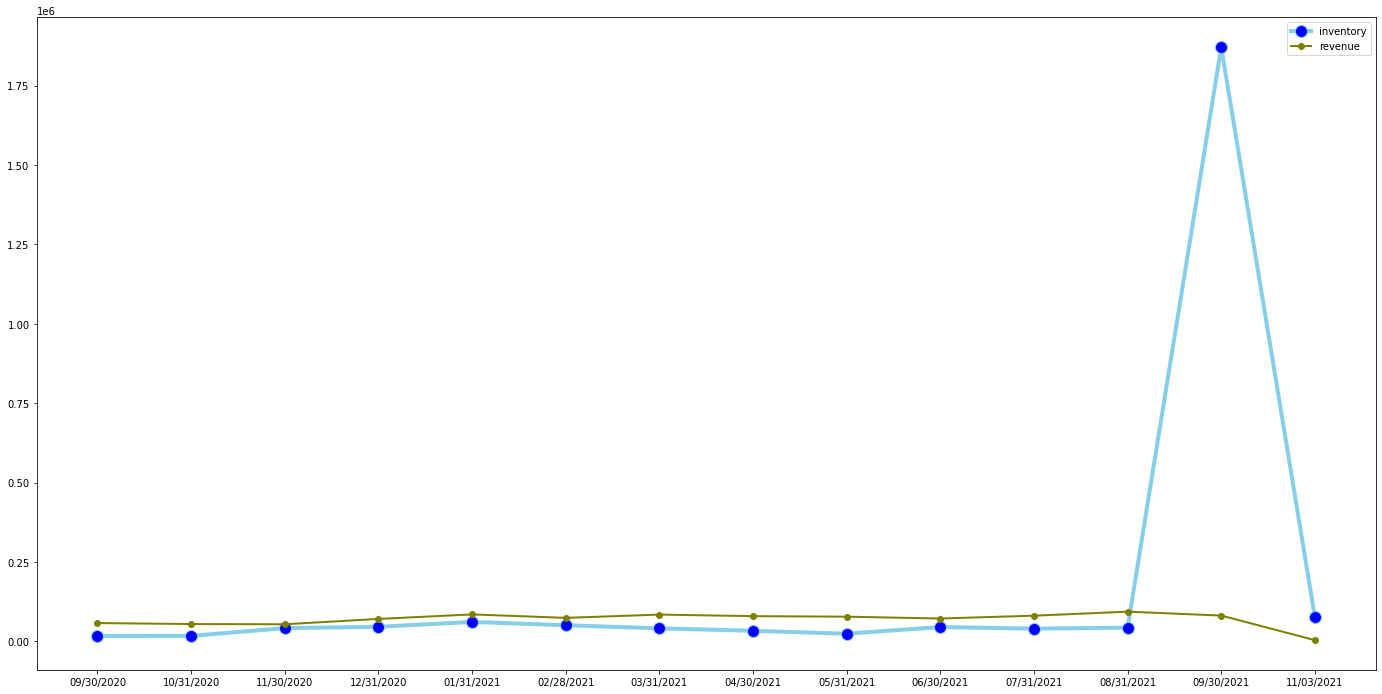

In [476]:
import importlib
importlib.reload(util)
importlib.reload(valuations_util)

valuations_util.plot_inventory_and_revenue(
    q=q,
    sales_receipts_dataframe=d.sales_receipts_dataframe,
    inventory_valuations=inventory_valuations
)

In [ ]:
# For debugging individual package histories
# You have to run the above block to reload the package_id_to_history array

import importlib
importlib.reload(util)
importlib.reload(valuations_util)

# Missing transactions?
# 5189649

# Using grams or missing transactions?
#WARN: seeing an incoming package for #19083030 with no received_datetime
#Exception: FATAL error, could not find a transfer to insert a tx with date
#2021-10-22 11:58:45+00:00 into for package 18218608

PACKAGE_IDS = [
    '1195820'
]

util.analyze_specific_package_histories(
    d, package_id_to_actual_row, PACKAGE_IDS, params=ANALYSIS_PARAMS)

In [270]:
inactive_packages_df = pandas.read_sql_query(
    util.are_packages_inactive_query(['766095']),
    engine
)
inactive_packages_df

,identifier,license_number,type,package_id,package_label,product_category_name,product_name,archiveddate,finisheddate,quantity
0,HPCC,C10-0000064-LIC,inactive,766095,1A406030000339D000000028,Leaf,wedding crasher trim,None,2020-02-22,0.0


In [273]:
# Find transfer packages in data warehouse by package_id.

def create_transfer_packages_by_package_id_query(package_id):
    return f"""
        select
            companies.identifier,
            company_deliveries.delivery_type,
            company_deliveries.updated_at,
            metrc_transfer_packages.package_id,
            metrc_transfer_packages.package_label,
            metrc_transfer_packages.shipped_quantity,
            metrc_transfer_packages.shipper_wholesale_price,
            metrc_transfers.shipper_facility_name,
            metrc_transfers.shipper_facility_license_number,
            metrc_deliveries.recipient_facility_name,
            metrc_deliveries.recipient_facility_license_number
        from
            metrc_transfer_packages
            inner join metrc_deliveries on metrc_transfer_packages.delivery_row_id = metrc_deliveries.id
            inner join metrc_transfers on metrc_deliveries.transfer_row_id = metrc_transfers.id
            inner join company_deliveries on metrc_transfers.id = company_deliveries.transfer_row_id
            inner join companies on company_deliveries.company_id = companies.id
        where
            True
            and metrc_transfer_packages.package_id = '{package_id}'
    """

transfer_packages_by_package_id_query = create_transfer_packages_by_package_id_query(
    766095)
transfer_packages_by_package_id_dataframe = pandas.read_sql_query(transfer_packages_by_package_id_query, engine)
transfer_packages_by_package_id_dataframe

,identifier,delivery_type,updated_at,package_id,package_label,shipped_quantity,shipper_wholesale_price,shipper_facility_name,shipper_facility_license_number,recipient_facility_name,recipient_facility_license_number
0,HPCC,INCOMING_UNKNOWN,2021-09-19 01:10:07.977000+00:00,766095,1A406030000339D000000028,7500.0,900.0,"GREEN SPECTRUM TRADING, INC.",C11-0000760-LIC,"HUENEME PATIENT CONSUMER COLLECTIVE, LLC.",C10-0000064-LIC


In [18]:
# Find packages in data warehouse by package_id.

def create_packages_by_package_id_query(package_id):
    return f"""
        select
            companies.identifier,
            metrc_packages.package_id,
            metrc_packages.package_label,
            metrc_packages.quantity
        from
            metrc_packages
            inner join companies on metrc_packages.company_id = companies.id
        where
            True
            and metrc_packages.package_id = '{package_id}'
    """

packages_by_package_id_query = create_packages_by_package_id_query(17481729)
packages_by_package_id_dataframe = pandas.read_sql_query(packages_by_package_id_query, engine)
packages_by_package_id_dataframe

,identifier,package_id,package_label,quantity
0,RA,17481729,1A4060300003BC9000058384,1.0



Package 5751573 arrived on 07/13/2020 with quantity 280 and price $350.0. {'package_row_id': '4544aa24-1a3d-494b-b312-de17db773e79', 'delivery_type': 'INCOMING_FROM_VENDOR', 'license_number': 'C10-0000596-LIC', 'manifest_number': '0000767939', 'created_date': datetime.date(2020, 7, 13), 'received_datetime': Timestamp('2020-07-15 00:56:06+0000', tz='UTC'), 'shipper_facility_license_number': 'C11-0000349-LIC', 'shipper_facility_name': 'MISSION HILLS PATIENTS COLLECTIVE', 'recipient_facility_license_number': 'C10-0000596-LIC', 'recipient_facility_name': 'ROYAL APOTHECARY L.L.C.', 'shipment_type_name': 'Wholesale Manifest', 'shipment_transaction_type': 'Wholesale', 'package_id': '5751573', 'package_label': '1A4060300003D59000009129', 'type': 'transfer_incoming', 'shipment_package_state': 'Accepted', 'is_testing_sample': False, 'is_trade_sample': False, 'product_category_name': 'Flower', 'product_name': 'Rich & Ruthless - CPT Kush Ride (28 GM Flower - SMS) (#112-CPTK-YF0420) #1884', 'packa

In [392]:
from bespoke.metrc.common import metrc_common_util

rest = metrc_common_util.get_rest_helper_for_debug(
    us_state='MA',
    license_number='MR281525'
)

In [360]:
from dateutil import parser
from datetime import timedelta

start_date = parser.parse('2020/01/01').date()
end_date = parser.parse('2020/01/01').date()

cur_date = start_date

while cur_date <= end_date:
    cur_date_str = cur_date.strftime('%m/%d/%Y')
    resp = rest.get('/transfers/v1/rejected', time_range=[cur_date_str])
    transfers = json.loads(resp.content)
    if len(transfers) > 0:
        print('FOUND SOME')
        break
        
    cur_date = cur_date + timedelta(days=1)
    

https://api-ca.metrc.com/transfers/v1/rejected?licenseNumber=C10-0000596-LIC&lastModifiedStart=2020-01-01T00:00:00


In [394]:
resp = rest.get('/packages/v1/967657')

https://api-ma.metrc.com/packages/v1/967657?licenseNumber=MR281525


In [391]:
os.environ['JUPYTER_NOTEBOOK_METRC_API_KEY'] = ''

In [390]:
os.environ['METRC_VENDOR_KEY_MA'] = ''